In [15]:

import itertools
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Activation, BatchNormalization, Conv1D, LeakyReLU, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from statsmodels.tsa.seasonal import seasonal_decompose
from keras import backend as K
from datetime import datetime, date
from numpy import array , hstack
import sklearn.metrics as sklm
import math


In [2]:
# Train and predict
# Load dataset
file_path = 'power_irridiance.csv'  # Replace with your file path
df = pd.read_csv(file_path, index_col= 'DateTime')
df.head(5)

,Power,Irradiance
DateTime,,
2021-01-05 01:00:00,0.0,0.0
2021-01-05 02:00:00,0.0,0.0
2021-01-05 03:00:00,0.0,0.0
2021-01-05 04:00:00,0.0,0.0
2021-01-05 05:00:00,0.0,0.0


In [3]:
df. describe()

,Power,Irradiance
count,30546.000000,30546.000000
mean,138.317503,148.984269
std,212.646880,233.051381
min,-0.003000,0.000000
25%,0.000000,0.000000
50%,4.668000,6.292500
75%,213.614750,221.790750
max,903.380000,1041.370000


In [4]:
df_1 = df.drop(columns=['Irradiance'])

In [34]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30546 entries, 2021-01-05 01:00:00 to 2024-07-22 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Power   30546 non-null  float64
dtypes: float64(1)
memory usage: 1.5+ MB


In [8]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length - 1):  # 1 steps ahead for prediction (3 days for hourly data)
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length:i + seq_length + 1, 0])  # Target is power for next 1 hours
    return np.array(x), np.array(y)

# Define LSTM model
# def build_lstm_model(input_shape):
#     model = Sequential()
#     model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units=64))
#     model.add(Dropout(0.2))
#     model.add(Dense(units=72))  # Predict next 72 steps (next 3 days)
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model



In [9]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_1)

# Sequence length (number of past hours to look at)
seq_length = 1  # Last 72 hours of data to predict the next 72 hours

# Prepare sequences
x, y = create_sequences(scaled_data, seq_length)

# Split into train and test sets
split = int(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

# Build and compile LSTM model
# model = build_lstm_model((x_train.shape[1], x_train.shape[2]))

# Train the model
# model_save = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

# Make predictions
# y_pred = model.predict(x_test)

In [10]:
def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
    
    return sklm.mean_squared_error(y_true, y_predicted), r2
   


In [11]:
def plot_res(y_test, y_score, label_test, label_score, dpi=100):
    plt.figure(figsize=(10,7), dpi=dpi)
    plt.plot(y_test, label=label_test)
    plt.plot(y_score, label=label_score)
    plt.legend(loc=1)
    plt.title('Y test vs. y_predict, lag ' )
    plt.show()

In [12]:
model_results = []

In [25]:
def LSTM_model(X_train, y_train, X_test, y_test,batch_size_= 12, dropout_=.3,epochs_=20, samples=24):
    

    
    # design network                                                                #
    model = Sequential()                                                            #
    model.add(LSTM(int(samples), input_shape=(X_train.shape[1], X_train.shape[2]))) #
    model.add(Dropout(dropout_))                                                    #
    model.add(Dense(1))                                                             #
    model.compile(loss='mean_squared_error', optimizer='adam')                      #
                                                                                    #
    # fit network                                                                   #
    history = model.fit(X_train,                                                    #
                        y_train,                                                    #
                        epochs=epochs_,                                             #
                        batch_size=batch_size_,                                     #
                        validation_data=(X_test, y_test),                           #
                        verbose=1,                                                  #
                        shuffle=False)                                              #
                                                                                    #
    # Save model for later                                                          #


    # uncomment to load
    #model = load_model('./models/1539911055_model_672_lag.h5') 

    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('Training lag ' + str(samples))
    plt.show()
    
    y_score = model.predict(X_test) 
    y_score = [x if x > 0 else 0 for x in y_score]
    (rmse, r2) = print_metrics(y_test, y_score, 28)
    plot_res(y_test, y_score, label_test = 'y_test', label_score='y_predict')
    
    # Save all the results
    
    model_results_dict = {}

    filename = str(int(time.time())) + '_model_' + str(samples) + '_lag.h5'         #save all training file
    model.save('./models/' + filename)                                              #
   

    model_results_dict['Algo'] = 'LSTM'
    model_results_dict['lag'] = samples
    model_results_dict['dropout'] = dropout_
    model_results_dict['epochs'] = epochs_
    model_results_dict['batch_size'] = batch_size_
    model_results_dict['loss'] = history.history
    model_results_dict['rmse'] = rmse
    model_results_dict['power_gen_rmse'] = math.sqrt(rmse)
    model_results_dict['r2'] = r2
    model_results_dict['model_filename'] = filename
    model_results_dict['time_ran'] = int(time.time())
    model_results.append(model_results_dict)
    
    return model, model_results_dict

Epoch 1/20
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 2s 778us/step - loss: 0.0215 - val_loss: 0.0077
Epoch 2/20
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - loss: 0.0107 - val_loss: 0.0076
Epoch 3/20
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - loss: 0.0103 - val_loss: 0.0076
Epoch 4/20
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - loss: 0.0103 - val_loss: 0.0076
Epoch 5/20
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - loss: 0.0101 - val_loss: 0.0076
Epoch 6/20
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - loss: 0.0101 - val_loss: 0.0075
Epoch 7/20
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - loss: 0.0101 - val_loss: 0.0076
Epoch 8/20
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - loss: 0.0101 - val_loss: 0.0075
Epoch 9/20
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - loss: 0.0100 - val_loss: 0.0075
Epoch 10/20
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - loss: 0.0100 - val_loss: 0.0075
Epoch 11/20
2037/2037 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - loss: 0.0101 - val_loss: 0.0075
Epoch 12

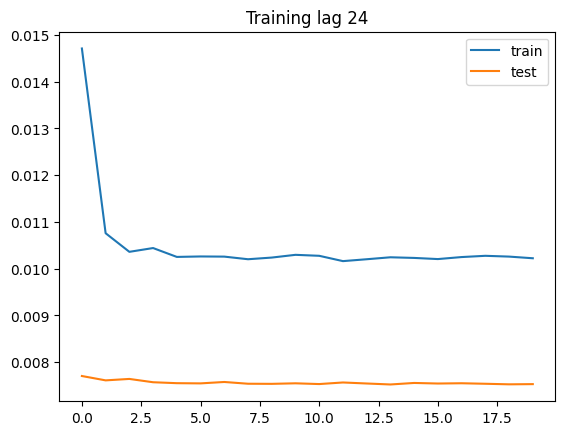

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
Mean Square Error      = 0.007532057868229569
Root Mean Square Error = 0.08678742920624835
Mean Absolute Error    = 0.05312780933102793
Median Absolute Error  = 0.01121242555211566
R^2                    = 0.8306004937259844
Adjusted R^2           = 0.8298483498895434


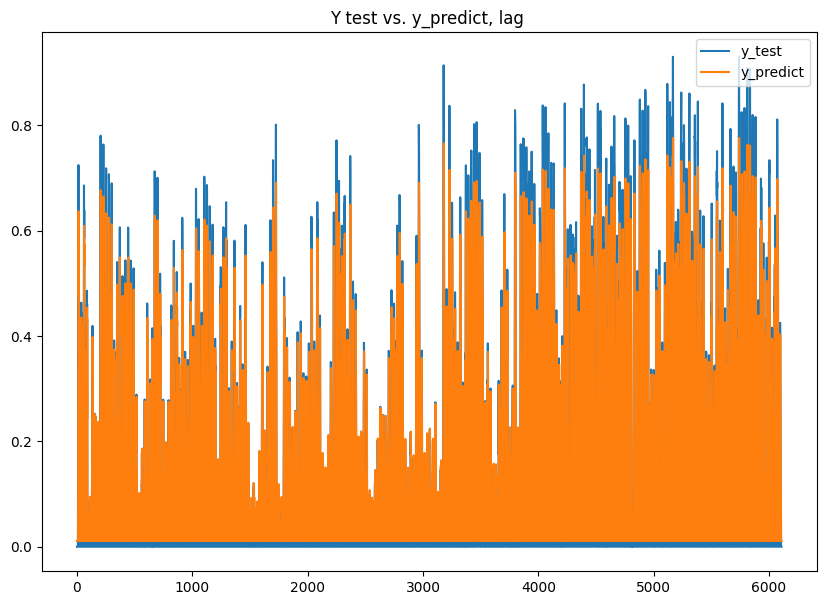

(<Sequential name=sequential_4, built=True>,
 {'Algo': 'LSTM',
  'lag': 24,
  'dropout': 0.3,
  'epochs': 20,
  'batch_size': 12,
  'loss': {'loss': [0.014711357653141022,
    0.01075983326882124,
    0.010361717082560062,
    0.010442742146551609,
    0.010252960957586765,
    0.010262739844620228,
    0.010259358212351799,
    0.010203413665294647,
    0.010239063762128353,
    0.010297585278749466,
    0.010276801884174347,
    0.010162957943975925,
    0.010203189216554165,
    0.010245101526379585,
    0.01023146789520979,
    0.010206859558820724,
    0.010249937884509563,
    0.0102766752243042,
    0.01025979034602642,
    0.010224255733191967],
   'val_loss': [0.007705597206950188,
    0.007612370420247316,
    0.007643129210919142,
    0.007572331465780735,
    0.007552312687039375,
    0.007547934539616108,
    0.0075779324397444725,
    0.007540387101471424,
    0.0075380029156804085,
    0.007549528032541275,
    0.007533402647823095,
    0.007567264139652252,
    0.007545

In [26]:
LSTM_model(x_train,y_train, x_test,y_test, samples=24)

In [17]:
model_results

[{'Algo': 'LSTM',
  'lag': 24,
  'dropout': 0.3,
  'epochs': 20,
  'batch_size': 12,
  'loss': {'loss': [0.017290500923991203,
    0.010853870771825314,
    0.010558905079960823,
    0.010265948250889778,
    0.010376346297562122,
    0.010322601534426212,
    0.01031752023845911,
    0.010317198000848293,
    0.010270980186760426,
    0.010250765830278397,
    0.010300595313310623,
    0.010281172581017017,
    0.010308347642421722,
    0.010243035852909088,
    0.010290948674082756,
    0.010295657441020012,
    0.010360026732087135,
    0.010313020087778568,
    0.01028471253812313,
    0.010243553668260574],
   'val_loss': [0.00773125933483243,
    0.007651279214769602,
    0.007595004979521036,
    0.007558153942227364,
    0.007562596350908279,
    0.007530885748565197,
    0.007525721564888954,
    0.007572137285023928,
    0.00752355856820941,
    0.0075547522865235806,
    0.00753772584721446,
    0.007577257696539164,
    0.007590897846966982,
    0.007531662937253714,
    0.